**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Load data](#toc2_)    
- [Data audit](#toc3_)    
- [Correlation Report](#toc4_)    
- [Analyze features](#toc5_)    
- [Saving to files](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports](#toc0_)

In [3]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from controller import Controller
from data_audit import DataAudit
from nonparamtests import calculate_chi_sq, calculate_kruskal, calculate_ami
from reporting import correlation_report

In [5]:
c = Controller('i01')

# <a id='toc2_'></a>[Load data](#toc0_)

In [6]:
filepath = fr'{c.get_path_data_prepared()}/01_df_development.pkl'
df_development = pd.read_pickle(filepath)

df_train = df_development.query('TRAIN_VAL_TEST_SPLIT == "Train"')
print(f'{df_train.shape=}')
df_val = df_development.query('TRAIN_VAL_TEST_SPLIT == "Val"')
print(f'{df_val.shape=}')
df_test = df_development.query('TRAIN_VAL_TEST_SPLIT == "Test"')
print(f'{df_test.shape=}')

df_development

df_train.shape=(86503, 20)
df_val.shape=(0, 20)
df_test.shape=(10813, 20)


,PROJECT_ID,NAME,DESC,GOAL,KEYWORDS,DISABLE_COMMUNICATION,COUNTRY,CURRENCY,DEADLINE,STATE_CHANGED_AT,CREATED_AT,LAUNCHED_AT,BACKERS_COUNT,FINAL_STATUS,CREATE_LAUNCH_HOURS,CREATE_LAUNCH_HOURS_LOG,CREATE_DEADLINE_HOURS,CREATE_DEADLINE_HOURS_LOG,LAUNCHED_DEADLINE_HOURS,TRAIN_VAL_TEST_SPLIT
0,kkst124894863,Mall Of The Internet,"First Virtual Reality Mall, eCommerce, Live Au...",60000.0,mall-of-the-internet,False,US,USD,2015-04-22 18:21:56,2015-04-22 18:21:56,2014-12-14 18:32:03,2015-03-23 18:21:56,4,0,2375.831389,7.773524,3095.831389,8.038135,720.000000,Train
1,kkst456144988,"The Don't Tell Darlings' New Album: """"""""""""""""""""...","""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",800.0,the-dont-tell-darlings-new-album-sugar-for-sugar,False,US,USD,2011-09-23 04:00:00,2011-09-23 04:00:53,2011-07-26 19:20:33,2011-07-31 18:47:42,41,1,119.452500,4.791255,1400.657500,7.245411,1281.205000,Train
2,kkst598563858,OPEN SOURCE GAME Busters Nuts!,Big Buck Bunny mobile game is a open source AP...,10000.0,busters-nuts,False,US,USD,2013-06-20 03:19:57,2013-06-20 03:19:57,2012-08-24 17:51:43,2013-05-16 03:19:57,1,0,6345.470556,8.755654,7185.470556,8.879955,840.000000,Train
3,kkst1129209536,Send SueNami - DRAG Olympic,Olympics for Drag Queens? From Dress to Succes...,270.0,send-suenami-drag-olympic,False,GB,GBP,2014-07-18 22:20:18,2014-07-18 22:20:18,2014-07-10 21:25:03,2014-07-10 22:20:18,0,0,0.920833,0.652759,192.920833,5.267450,192.000000,Train
4,kkst8900047,Knowing Nile S,"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""...",5.0,knowing-nile-s,False,GB,GBP,2013-11-10 16:51:02,2013-11-10 16:51:02,2013-09-07 08:37:01,2013-10-11 15:51:02,0,0,823.233611,6.714454,1544.233611,7.342930,721.000000,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108124,kkst1377169294,Somewhere Out There,"Creating a smile, not just any smile, the smil...",250.0,somewhere-out-there,False,US,USD,2014-09-14 03:00:00,2014-09-14 03:00:10,2014-07-18 21:49:37,2014-08-22 16:55:17,24,1,835.094444,6.728742,1373.173056,7.225607,538.078611,Test
108125,kkst450010306,Time Tracker Android Application,Time tracker is an application that calculates...,5000.0,time-tracker-android-application,False,US,USD,2013-05-02 18:39:22,2013-05-02 18:39:25,2013-03-21 20:50:18,2013-04-02 18:39:22,0,0,285.817778,5.658847,1005.817778,6.914550,720.000000,Test
108126,kkst280861137,Living Ruins,A public sculpture and its documentary to show...,45000.0,living-ruins,False,CA,CAD,2015-04-22 01:13:36,2015-04-22 01:13:38,2015-03-10 02:17:17,2015-03-23 01:13:36,36,0,310.938611,5.742806,1030.938611,6.939194,720.000000,Test
108127,kkst1638562722,"iCulture Collection - fine poster prints, stic...",iCulture project is a comprehensive detailed c...,3000.0,iculture-collection-fine-poster-prints-sticker...,False,US,USD,2013-11-21 19:09:13,2013-11-12 00:39:08,2013-10-16 09:31:06,2013-10-22 18:09:13,0,0,152.635278,5.034581,873.635278,6.773807,721.000000,Test


In [7]:
df_development['FINAL_STATUS'].value_counts()

0    73568
1    34561
Name: FINAL_STATUS, dtype: int64

# <a id='toc3_'></a>[Data audit](#toc0_)

In [8]:
data_audit_train = DataAudit()
data_audit_train.fit(df_train)
data_audit_train.view_summary()

100%|██████████| 20/20 [00:02<00:00,  7.50it/s, Processing TRAIN_VAL_TEST_SPLIT]     


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,PROJECT_ID,.,object,1.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.
1,NAME,.,object,0.9977,0.0,NaN,<NA>,NaN,NaN,NaN,.
2,DESC,.,object,0.9943,0.0,NaN,<NA>,NaN,NaN,NaN,.
3,GOAL,.,float64,0.0359,0.0,39137.091602,1065293.804231,0.01,5000.0,100000000.0,.
4,KEYWORDS,.,object,1.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.
5,DISABLE_COMMUNICATION,.,bool,0.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.
6,COUNTRY,.,object,0.0001,0.0,NaN,<NA>,NaN,NaN,NaN,.
7,CURRENCY,.,object,0.0001,0.0,NaN,<NA>,NaN,NaN,NaN,.
8,DEADLINE,.,datetime64[ns],0.9422,0.0,2013-09-28 03:03:03.210559232,<NA>,2009-05-03 06:59:59,2014-03-02 16:24:16,2015-05-31 18:28:58,.
9,STATE_CHANGED_AT,.,datetime64[ns],0.9548,0.0,2013-09-27 00:12:26.205507072,<NA>,2009-05-03 07:00:17,2014-03-01 20:47:04,2015-05-31 18:29:00,.


In [9]:
object_features = df_train.select_dtypes('object').columns
amis = calculate_ami(df_train, object_features, df_train['FINAL_STATUS'])
amis = amis.map('{:.6f}'.format)
amis

PROJECT_ID              0.000000
NAME                    0.000023
DESC                    0.000230
KEYWORDS                0.000000
COUNTRY                 0.005168
CURRENCY                0.005169
TRAIN_VAL_TEST_SPLIT    0.000000
Name: AMI, dtype: object

In [10]:
# COUNTRY and CURRENCY have pvalue < 0.5

chi_sqs = calculate_chi_sq(df_train, object_features, df_train['FINAL_STATUS'])
chi_sqs = chi_sqs.map('{:.6f}'.format)
chi_sqs

PROJECT_ID              0.498401
NAME                    0.481484
DESC                    0.333223
KEYWORDS                0.498401
COUNTRY                 0.000000
CURRENCY                0.000000
TRAIN_VAL_TEST_SPLIT    1.000000
Name: PVALUE_CHI_SQUARE, dtype: object

In [103]:
# BACKERS_COUNT has pvalue < 0.5

numeric_features = df_train.select_dtypes('number').columns
kruskal_pvalues = calculate_kruskal(df_train, numeric_features, df_train['FINAL_STATUS'])
kruskal_pvalues = kruskal_pvalues.map('{:.6f}'.format)
kruskal_pvalues

GOAL                         0.999942
BACKERS_COUNT                0.000002
FINAL_STATUS                 0.535261
CREATE_LAUNCH_HOURS          1.000000
CREATE_LAUNCH_HOURS_LOG      1.000000
CREATE_DEADLINE_HOURS        1.000000
CREATE_DEADLINE_HOURS_LOG    1.000000
LAUNCHED_DEADLINE_HOURS      1.000000
Name: PVALUE_KRUSKAL, dtype: object

In [104]:
data_audit_train.extend_summary([chi_sqs, amis, kruskal_pvalues])
data_audit_train.view_summary()

,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT,PVALUE_CHI_SQUARE,PVALUE_KRUSKAL
0,PROJECT_ID,.,object,1.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.498401,NaN
1,NAME,.,object,0.9977,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.481484,NaN
2,DESC,.,object,0.9943,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.333223,NaN
3,GOAL,.,float64,0.0359,0.0,39137.091602,1065293.804231,0.01,5000.0,100000000.0,.,NaN,0.999942
4,KEYWORDS,.,object,1.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.498401,NaN
5,DISABLE_COMMUNICATION,.,bool,0.0000,0.0,NaN,<NA>,NaN,NaN,NaN,.,NaN,NaN
6,COUNTRY,.,object,0.0001,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.000000,NaN
7,CURRENCY,.,object,0.0001,0.0,NaN,<NA>,NaN,NaN,NaN,.,0.000000,NaN
8,DEADLINE,.,datetime64[ns],0.9422,0.0,2013-09-28 03:03:03.210559232,<NA>,2009-05-03 06:59:59,2014-03-02 16:24:16,2015-05-31 18:28:58,.,NaN,NaN
9,STATE_CHANGED_AT,.,datetime64[ns],0.9548,0.0,2013-09-27 00:12:26.205507072,<NA>,2009-05-03 07:00:17,2014-03-01 20:47:04,2015-05-31 18:29:00,.,NaN,NaN


# <a id='toc4_'></a>[Correlation Report](#toc0_)

In [14]:
corr_df = correlation_report(df_train)
corr_df

,variable_x,variable_y,pearson,spearman
0,GOAL,DISABLE_COMMUNICATION,-0.000795,-0.019793
1,GOAL,BACKERS_COUNT,0.008057,0.143645
2,GOAL,FINAL_STATUS,-0.018869,-0.185351
3,GOAL,CREATE_LAUNCH_HOURS,-0.000558,0.243606
4,GOAL,CREATE_LAUNCH_HOURS_LOG,-0.000125,0.243606
...,...,...,...,...
59,LAUNCHED_DEADLINE_HOURS,FINAL_STATUS,-0.093337,-0.073106
60,LAUNCHED_DEADLINE_HOURS,CREATE_LAUNCH_HOURS,0.003584,0.048879
61,LAUNCHED_DEADLINE_HOURS,CREATE_LAUNCH_HOURS_LOG,-0.026841,0.048879
62,LAUNCHED_DEADLINE_HOURS,CREATE_DEADLINE_HOURS,0.149625,0.509336


# <a id='toc5_'></a>[Analyze features](#toc0_)

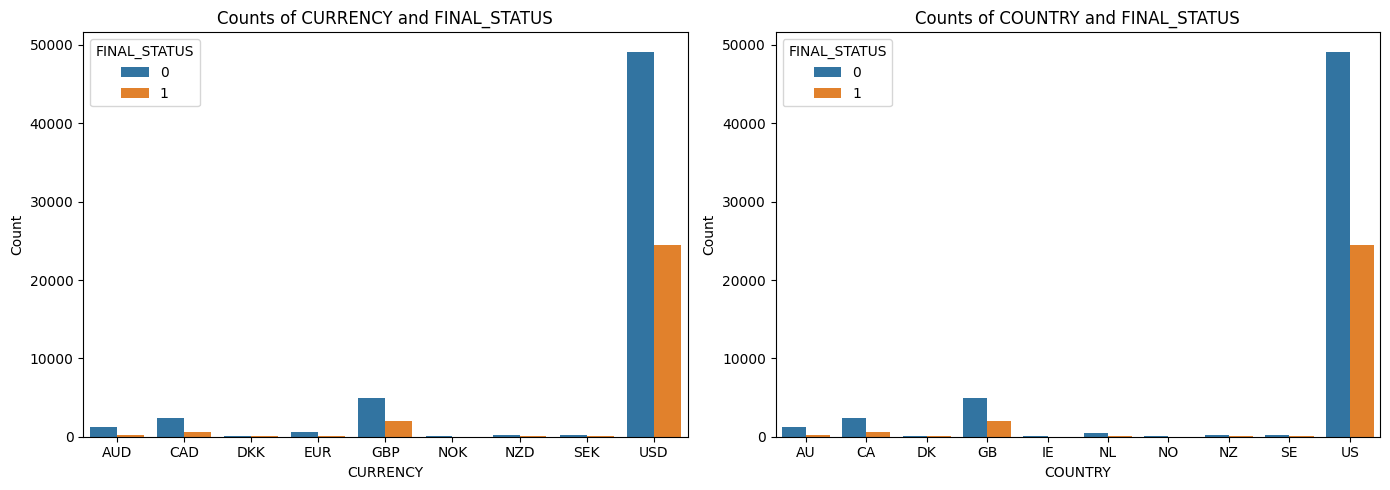

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

counts1 = df_train.groupby(['CURRENCY', 'FINAL_STATUS']).size().reset_index(name='Count')
sns.barplot(data=counts1, x='CURRENCY', y='Count', hue='FINAL_STATUS', ax=ax1)
ax1.set_xlabel('CURRENCY')
ax1.set_ylabel('Count')
ax1.set_title('Counts of CURRENCY and FINAL_STATUS')

counts2 = df_train.groupby(['COUNTRY', 'FINAL_STATUS']).size().reset_index(name='Count')
sns.barplot(data=counts2, x='COUNTRY', y='Count', hue='FINAL_STATUS', ax=ax2)
ax2.set_xlabel('COUNTRY')
ax2.set_ylabel('Count')
ax2.set_title('Counts of COUNTRY and FINAL_STATUS')

plt.tight_layout()
plt.show()

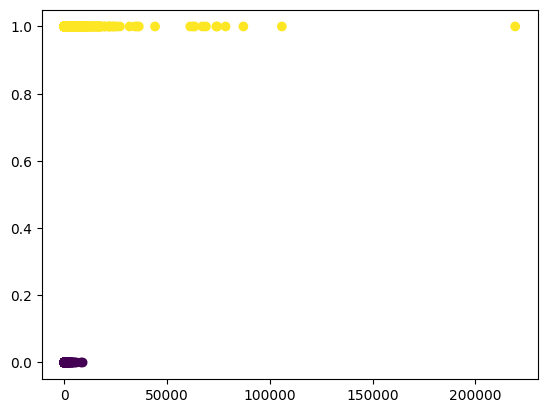

In [107]:
plt.scatter(df_train['BACKERS_COUNT'], df_train['FINAL_STATUS'], c=df_train['FINAL_STATUS'])
plt.show()

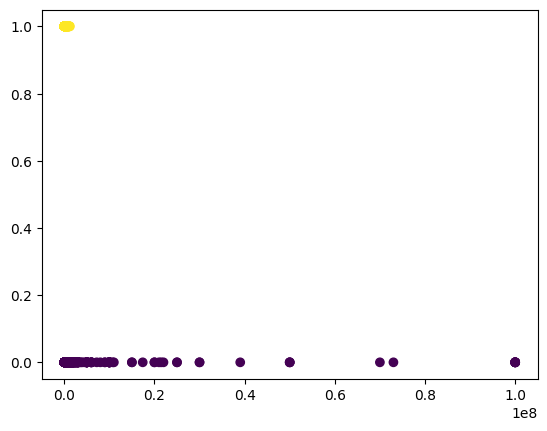

In [108]:
plt.scatter(df_train['GOAL'], df_train['FINAL_STATUS'], c=df_train['FINAL_STATUS'])
plt.show()

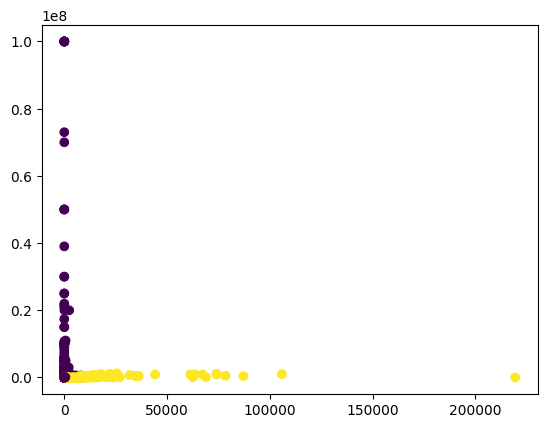

In [109]:
plt.scatter(df_train['BACKERS_COUNT'], df_train['GOAL'], c=df_train['FINAL_STATUS'])
plt.show()

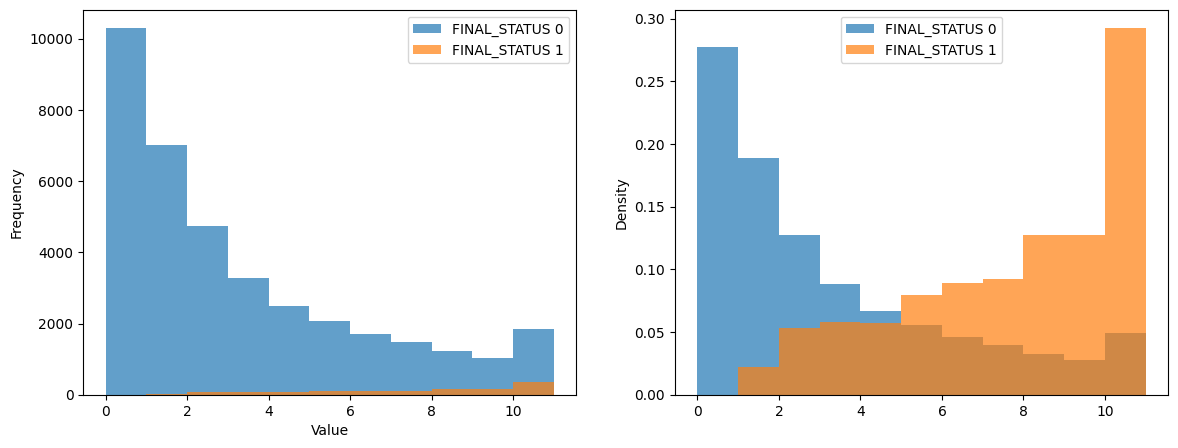

In [110]:
data_status_0 = df_train[df_train['FINAL_STATUS'] == 0]['BACKERS_COUNT']
data_status_1 = df_train[df_train['FINAL_STATUS'] == 1]['BACKERS_COUNT']

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(data_status_0, bins=range(12), alpha=0.7, label='FINAL_STATUS 0')
ax1.hist(data_status_1, bins=range(12), alpha=0.7, label='FINAL_STATUS 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(data_status_0, bins=range(12), alpha=0.7, label='FINAL_STATUS 0', density=True)
ax2.hist(data_status_1, bins=range(12), alpha=0.7, label='FINAL_STATUS 1', density=True)
ax2.set_ylabel('Density')
ax2.legend()

plt.show()

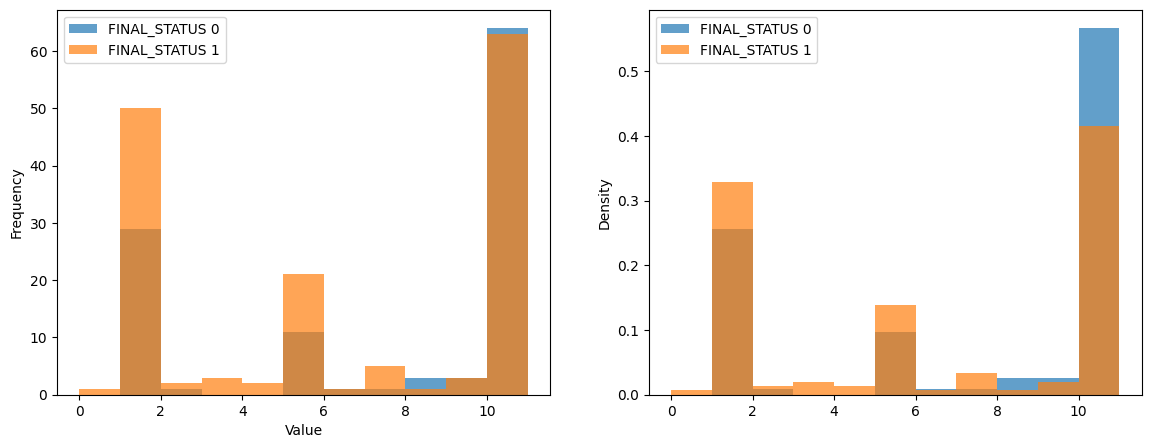

In [111]:
data_status_0 = df_train[df_train['FINAL_STATUS'] == 0]['GOAL']
data_status_1 = df_train[df_train['FINAL_STATUS'] == 1]['GOAL']

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(data_status_0, bins=range(12), alpha=0.7, label='FINAL_STATUS 0')
ax1.hist(data_status_1, bins=range(12), alpha=0.7, label='FINAL_STATUS 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(data_status_0, bins=range(12), alpha=0.7, label='FINAL_STATUS 0', density=True)
ax2.hist(data_status_1, bins=range(12), alpha=0.7, label='FINAL_STATUS 1', density=True)
ax2.set_ylabel('Density')
ax2.legend()

plt.show()

# <a id='toc6_'></a>[Saving to files](#toc0_)

In [11]:
filepath = f'{c.get_path_iteration()}/data_audit_train.xlsx'
data_audit_train.export(filepath)

20it [03:53, 11.67s/it, Exporting TRAIN_VAL_TEST_SPLIT]     


In [15]:
filepath = f'{c.get_path_iteration()}/correlation_report.xlsx'
corr_df.to_excel(filepath)